# TensorFlowのモデルを純粋なTensorRTでコンバートする方法

純粋なTensorRTの方が速度向上は著しいです。その代わりコードの記述量が増し、推論用のコードの変更も変更されるので求める推論速度がクリティカルなケースでしか推奨できません。


動画解析のDeepStreamは純粋なTensorRTの動作しかサポートしていないため、この方法での作成が必要になります

In [0]:
import tensorrt as trt
import ctypes
import os
import graphsurgeon as gs
import tensorflow as tf
import uff
import numpy as np

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# ネットワークにつながっている場合のみ

ネットワーク上から学習済みモデルを取得して保存します

In [0]:
import requests
import tarfile

ssd_faster_net = 'http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz'
ssd_model_name = os.path.basename(ssd_faster_net)
resplace_ssd_model_name = ssd_model_name.replace('.tar.gz', '')

r = requests.get(ssd_faster_net)

with open('./' + ssd_model_name, 'wb') as f:  
    f.write(r.content)

with tarfile.open(ssd_model_name, 'r:gz') as tf:
    tf.extractall(path='./')


モデルが保存してあるパスを指定します

In [0]:
resplace_ssd_model_name = "ssd_mobilenet_v2_coco_2018_03_29"

TensorFlowのフローズングラフを操作してTensorRTに変更するため、`gs.DynamicGraph`を使用して読み込みます。

In [0]:
dynamic_graph = gs.DynamicGraph(resplace_ssd_model_name + '/frozen_inference_graph.pb')

W0819 12:14:49.789322 548535341072 deprecation_wrapper.py:119] From /usr/lib/python3.6/dist-packages/graphsurgeon/StaticGraph.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



複雑な計算などがなく値が保管されているのみの役割の"Identity"ノードを検索して削除します。

"Identity"ノードの説明
https://stackoverflow.com/questions/34877523/in-tensorflow-what-is-tf-identity-used-for

"forward_inpus"
https://docs.nvidia.com/deeplearning/sdk/tensorrt-api/python_api/graphsurgeon/graphsurgeon.html#graphsurgeon.DynamicGraph.forward_inputs

In [0]:
all_identity_nodes = dynamic_graph.find_nodes_by_op("Identity")
dynamic_graph.forward_inputs(all_identity_nodes)

ここからTensorRTで標準でサポートされていないノードを作成しています。

サポートされているレイヤーは下記です。

https://docs.nvidia.com/deeplearning/sdk/tensorrt-support-matrix/index.html

In [0]:
import tensorflow as tf
TRT_INPUT_NAME = 'input'
height = 300
width = 300
channels = 3

input_plugin = gs.create_plugin_node(
    name=TRT_INPUT_NAME,
    op="Placeholder",
    dtype=tf.float32,
    shape=[1, height, width, channels])

SSDの特徴量マップのサイズを導出しています。

SSDはマルチスケールな特徴を用いて予測をしており、BoxPredictorが６つなので６つ設定しています。

画像のサイズに依存して特徴量マップのサイズが異なるので`width`に画像サイズを設定しています。

![SSD](./images/single_shot_multibox_detector.png)

In [0]:
def _get_feature_map_shape():
    width = 300
    fms = []
    curr = int(np.ceil(width / 16.0))
    for i in range(6):
        fms.append(curr)
        curr = int(np.ceil(curr / 2.0))
    return fms


物体検出では多数のBounding Boxが発生します。これらすべてに対してロスを計算するのはムダなのである程度、正解に近いものだけを残してロスの導出を行います。

![multi_bounding_box](./images/multi_bounding_box.png)

"priorbox"は予測されたBounding Boxに各種変換をかけてIoU（正解画像とのマッチ率）が高いものだけを採用する手法になります。

アスペクト比、スケーリングを変更してBounding Boxのバラエティーを多用にしてターゲットに近いものを導出できるように最適化されます。

https://lambdalabs.com/blog/how-to-implement-ssd-object-detection-in-tensorflow/

- name: カスタム対象のレイヤー名
- op: TensorRTで変換後の名前
- minSize: 最小サイズ
- maxSize: 最大サイズ
- aspectRatios: 適用するアスペクト比のリスト
- variance: min_y, min_x, 高さ, 幅に対するスケーリングの分散
- featureMapShapes: 6つの"priorbox"が発生するため、各"priorbox"の特徴量マップの設定
- numLayers: 対象となるレイヤーの数
    
下記のリンクに`SSD mobile net v2`のリンクがあるのでそれを元に設定します。

https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config

特徴量のスケールは入力が300x300の場合は19x19, 10x10, 5x5, 3x3, 2x2, 1x1になります。

In [0]:
priorbox_plugin = gs.create_plugin_node(
    name="priorbox",
    op="GridAnchor_TRT",
    minSize=0.2,
    maxSize=0.95,
    aspectRatios=list([1.0, 2.0, 0.5, 3.0, 0.3333]),
    variance=[
        1.0 / 10.0, 
        1.0 / 10.0,
        1.0 / 5.0,
        1.0 / 5.0
    ],
    featureMapShapes=_get_feature_map_shape(),
    numLayers=6)
_get_feature_map_shape()

[19, 10, 5, 3, 2, 1]

重複したBounding Boxを計算に使用したくないため、重複率が一定以上のBounding Boxを排除するためnon-maximum suppression(nms)を使用します。

![non-maximum_suppression](./images/non-maximum_suppression.png)

https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/


- shareLocation: クラスごとにボックスを設定するかしないか
- varianceEncodedInTarget: 分散で予測値を調整するかどうかの関数、0の場合は予測値をそのまま使用
- backgroundLabelId: 背景ラベルのId
- confidenceThreshold: クラス識別の敷居値
- nmsThreshold: Bounding Box重複の敷居値
- topK: 重複評価対象 
- keepTopK: 削除後にキープする数
- numClasses: クラス数 + 背景
- inputOrder: 入力次元の順序 
- confSigmoid: クラスの確信度にシグモイド関数をかけるかどうかの設定
-  isNormalized: 正規化をかけるかどうかの設定
- codeTyep: 0から3で表記。それぞれの処理内容はこの[リンク](https://github.com/NVIDIA/TensorRT/tree/release/5.1/plugin/nmsPlugin#codetype)にあります。
 - CORNER = 0
 - CENTER_SIZE = 1
 - CORNER_SIZE = 2
 - TF_CENTER = 3


パラメータ詳細

https://docs.nvidia.com/deeplearning/sdk/tensorrt-api/c_api/structnvinfer1_1_1plugin_1_1_n_m_s_parameters.html

https://docs.nvidia.com/deeplearning/sdk/tensorrt-api/c_api/structnvinfer1_1_1plugin_1_1_detection_output_parameters.html

In [0]:
TRT_OUTPUT_NAME = 'nms'

nms_plugin = gs.create_plugin_node(
    name=TRT_OUTPUT_NAME,
    op="NMS_TRT",
    shareLocation=1,
    varianceEncodedInTarget=0,
    backgroundLabelId=0,
    confidenceThreshold=1e-8,
    nmsThreshold=0.6,
    topK=100,
    keepTopK=100,
    numClasses=90 + 1,  # add background
    inputOrder=[1, 0, 2], 
    confSigmoid=1,
    isNormalized=1,
    scoreConverter="SIGMOID",
    codeType=3)

"priorbox"と"Bounding Box"の位置と確信度のカスタムプラグインを作成します。

In [0]:
priorbox_concat_plugin = gs.create_node(
        "priorbox_concat", op="ConcatV2", dtype=tf.float32, axis=2)

boxloc_concat_plugin = gs.create_plugin_node(
    "boxloc_concat",
    op="FlattenConcat_TRT",
    dtype=tf.float32,
)

boxconf_concat_plugin = gs.create_plugin_node(
    "boxconf_concat",
    op="FlattenConcat_TRT",
    dtype=tf.float32,
)

変換予定のノードと先ほど設定したカスタムプラグインをマッピングします。

マッピングされたノードはTensorRTのノードに変換されます。

In [0]:
namespace_plugin_map = {
    "MultipleGridAnchorGenerator": priorbox_plugin,
    "Postprocessor": nms_plugin,
    "Preprocessor": input_plugin,
    "ToFloat": input_plugin,
    "image_tensor": input_plugin,
    "Concatenate": priorbox_concat_plugin,
    "concat": boxloc_concat_plugin,
    "concat_1": boxconf_concat_plugin
}

dynamic_graph.collapse_namespaces(namespace_plugin_map)


新たに入力の設定を行うのでグラフの入力のノードを除去します。

In [0]:
for i, name in enumerate(
        dynamic_graph.find_nodes_by_op('NMS_TRT')[0].input):
    if TRT_INPUT_NAME in name:
        dynamic_graph.find_nodes_by_op('NMS_TRT')[0].input.pop(i)


後続処理で出力内容をパースするため、依存性のある部分は除いてグラフの出力層を除去します。

UFF formatで扱うためuff_buffer形式に変換します。

UFF format(CADなどで用いられるデータフォーマットです。CADの内容を表現可能なフォーマットをディープラーニングでも流用するため使用)
https://en.wikipedia.org/wiki/Universal_File_Format

In [0]:
dynamic_graph.remove(
    dynamic_graph.graph_outputs, remove_exclusive_dependencies=False)

uff_buffer = uff.from_tensorflow(dynamic_graph.as_graph_def(),
                                 [TRT_OUTPUT_NAME])

NOTE: UFF has been tested with TensorFlow 1.12.0. Other versions are not guaranteed to work


W0819 12:24:44.089948 548535341072 deprecation_wrapper.py:119] From /usr/lib/python3.6/dist-packages/uff/converters/tensorflow/converter.py:179: The name tf.AttrValue is deprecated. Please use tf.compat.v1.AttrValue instead.



UFF Version 0.6.3
=== Automatically deduced input nodes ===
[name: "input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 1
      }
      dim {
        size: 300
      }
      dim {
        size: 300
      }
      dim {
        size: 3
      }
    }
  }
}
]

Using output node nms
Converting to UFF graph
Converting nms as custom op: NMS_TRT
Converting priorbox as custom op: GridAnchor_TRT
Converting boxloc_concat as custom op: FlattenConcat_TRT
Converting boxconf_concat as custom op: FlattenConcat_TRT
No. nodes: 1094


6つの"Bounding Box"を合わせる"FlattenConcat_TRT"はTensorRTではサポートしていないのでC++のTensorRTで実装したものを使用します。下記の関数はC++で記述された関数を読み込むためのものです。

In [0]:
def load_plugins():
    library_path = os.path.join(
        "./", 'libssd_tensorrt.so')
    ctypes.CDLL(library_path)


# TensorRTに変換するための関数

- trt.Logger(trt.Logger.INFO) as logger
 - TensorRTで変換するときのログレベルを設定
- trt.Builder(logger) as builder
 - ネットワークの定義をTensorRTエンジンに変換するBuilder
- builder.create_network() as network
 - ネットワークの定義をオブジェクトとして作成
- trt.UffParser() as parser
 - UFFをパースするためのパーサー
 
# 最適化に20〜30分かかります。

In [0]:
%%time


with trt.Logger(trt.Logger.INFO) as logger, trt.Builder(logger) as builder, \
        builder.create_network() as network, trt.UffParser() as parser:

    # init built in plugins
    # TensorRTの予測プラグインの初期化とTensorRTプラグインの登録
    trt.init_libnvinfer_plugins(logger, '')

    # load jetbot plugins
    # C++で記述したプラグインの読み込み
    load_plugins()

    # 読み込んだuff形式のデータをメタグラフに変換するためのインスタンス
    meta_graph = uff.model.uff_pb2.MetaGraph()
    # uff形式のデータを読み込んでメタグラフに変換
    meta_graph.ParseFromString(uff_buffer)

    # メタグラフから入力のノード数を取得
    input_node = None
    for n in meta_graph.ListFields()[3][1][0].nodes:
        if 'Input' in n.operation:
            input_node = n

    channels = input_node.fields['shape'].i_list.val[3]
    height = input_node.fields['shape'].i_list.val[1]
    width = input_node.fields['shape'].i_list.val[2]

    # parse uff to create network
    # 入力のカスタムレイヤーを登録
    parser.register_input(TRT_INPUT_NAME, (channels, height, width))
    # 出力のレイヤーを登録
    parser.register_output(TRT_OUTPUT_NAME)
    # UFFバッファーをパースしてメモリに展開
    parser.parse_buffer(uff_buffer, network)

    # TensorRT parameter
    # 予測精度の設定
    builder.fp16_mode = True
    # 最大のバッチサイズ
    builder.max_batch_size = 1
    # TensorRTを実行、変換に使用するGPUメモリサイズ
    builder.max_workspace_size = 1 << 30
    # 最適なレイヤーを選択するための実行テストの最小回数
    builder.min_find_iterations = 2
    # 最適なレイヤーを選択するための実行テストの平均回数
    builder.average_find_iterations = 1
    # 厳密な型制約がある場合に有効にする。
    builder.strict_type_constraints = False

    # ネットワーク定義からTensorRTエンジンの作成
    engine = builder.build_cuda_engine(network)

CPU times: user 48.5 s, sys: 14min 49s, total: 15min 38s
Wall time: 17min 37s


変換したモデルを保存します

In [0]:
with open("tensorrt_ssd_mobilenet_v2_coco.engine", "wb") as f:
    f.write(engine.serialize())

TensorRTに変換するときと同様の手順です

カスタムレイヤーはロードしておかないと保存したモデルをロードできません。

In [0]:
logger = trt.Logger()
trt.init_libnvinfer_plugins(logger, '')
load_plugins()

runtime = trt.Runtime(logger)

TensorRTを読み込むときの手順です

In [0]:
%%time
with open("./tensorrt_ssd_mobilenet_v2_coco.engine", 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())

CPU times: user 1.9 s, sys: 1.28 s, total: 3.18 s
Wall time: 9.41 s


GPUなどのデバイスメモリを割り当てずにTensorRTエンジンを実行するためのオブジェクトを作成します。

割り当ては実行時に行われます。

In [0]:
context = engine.create_execution_context()

予測処理に用いる画像を読みこみ、サイズを変換します。

In [0]:
from PIL import Image
IMAGE_PATH = 'data/huskies.jpg'

image = Image.open(IMAGE_PATH)

image_resized = np.array(image.resize((300, 300)))
image = np.array(image_resized)

入力した画像をRGBごとに正規化して推論のためにバッチサイズを加えます。

In [0]:
import cv2

def bgr8_to_ssd_input(input_value):
    mean = 255.0 * np.array([0.5, 0.5, 0.5])
    stdev = 255.0 * np.array([0.5, 0.5, 0.5])
    x = input_value
    x = x.transpose((2, 0, 1)).astype(np.float32)
    x -= mean[:, None, None]
    x /= stdev[:, None, None]
    return x[None, ...]

推論の前処理はPyTorchの方がやりやすいためPyTorchのフォーマットに変換します。

下記でtensorrtの型に合わせてPyTorchのデータの型を変換する関数を定義します。

In [0]:
import torch

def torch_dtype_from_trt(dtype):
    if dtype == trt.int8:
        return torch.int8
    elif dtype == trt.int32:
        return torch.int32
    elif dtype == trt.float16:
        return torch.float16
    elif dtype == trt.float32:
        return torch.float32
    else:
        raise TypeError('%s is not supported by torch' % dtype)

PyTorchのデバイスに合わせてTensorRTのデバイスを変換する関数を定義します。

In [0]:
def torch_device_to_trt(device):
    if device.type == torch.device('cuda').type:
        return trt.TensorLocation.DEVICE
    elif device.type == torch.device('cpu').type:
        return trt.TensorLocation.HOST
    else:
        return TypeError('%s is not supported by tensorrt' % device)

逆にTensorRTのデバイスに合わせてPyTorchのデバイスに変換する関数を定義します。

In [0]:
def torch_device_from_trt(device):
    if device == trt.TensorLocation.DEVICE:
        return torch.device('cuda')
    elif device == trt.TensorLocation.HOST:
        return torch.device('cpu')
    else:
        return TypeError('%s is not supported by torch' % device)

TensorRTで推論を行う場合は出力のGPU処理を行うバッファーを作成する必要があります。そのための関数です。

In [0]:
def create_output_buffers(batch_size, output_names, engine, final_shapes=None):
    # 出力に関係するレイヤー数分のlistを確保します。
    outputs = [None] * len(output_names)
    for i, output_name in enumerate(output_names):
        # TensorRTエンジンの出力名ごとのインデックスを取得します。
        idx = engine.get_binding_index(output_name)
        # TensorRTのインデックスからデータの型を取得してPyTorchの型に変換します。
        dtype = torch_dtype_from_trt(engine.get_binding_dtype(idx))
        if final_shapes is not None:
            shape = (batch_size, ) + final_shapes[i]
        else:
            # バッチサイズとインデックスから取得したTensorRTのサイズを合わせます。
            shape = (batch_size, ) + tuple(engine.get_binding_shape(idx))
        # TensorRTのインデックスからGPUかCPU処理かを取得し、PyTorchのデバイスタイプに設定します。
        device = torch_device_from_trt(engine.get_location(idx))
        # 求めたshapeとdtypeとdeviceを用いてPyTorch上の空のarrayを設定します。
        output = torch.empty(size=shape, dtype=dtype, device=device)
        outputs[i] = output
    return outputs

TensorRTで推論実行するための関数です。

In [0]:
def execute_trt(context, engine, *inputs):
    batch_size = inputs[0].shape[0]
    
    input_names = ['input']
    output_names = ['nms', 'nms_1']

    bindings = [None] * (len(input_names) + len(output_names))

    # map input bindings
    # 入力に関係するレイヤー数分のlistを確保します。
    inputs_torch = [None] * len(input_names)
    for i, name in enumerate(input_names):
        # TensorRT上の入力の名前のインデックスを取得します。
        idx = engine.get_binding_index(name)

        # 入力をnumpy形式で用意します。
        inputs_torch[i] = torch.from_numpy(inputs[i])
        # インデックスからデバイス情報を取得し、PyTorchに設定、データのフォーマットをデバイスに合わせた形に変更します。
        inputs_torch[i] = inputs_torch[i].to(torch_device_from_trt(engine.get_location(idx)))
        # インデックスから型情報を取得し、PyTorchに設定、データの型を変更します。
        inputs_torch[i] = inputs_torch[i].type(torch_dtype_from_trt(engine.get_binding_dtype(idx)))

        # 確保した入力データのサイズ分、bindingsを確保します。
        bindings[idx] = int(inputs_torch[i].data_ptr())

    output_buffers = create_output_buffers(batch_size, output_names, engine)

    # map output bindings
    for i, name in enumerate(output_names):
        # TensorRT上のレイヤーの名前のインデックスを取得します。
        idx = engine.get_binding_index(name)
        # 確保した出力バッファーのサイズ分、bindingsを確保します。
        bindings[idx] = int(output_buffers[i].data_ptr())

    # TensorRTを実行する。出力結果は確保したbindingsに出力されます。
    context.execute(batch_size, bindings)

    # 実行結果をGPUからCPUに移します。
    outputs = [buffer.cpu().numpy() for buffer in output_buffers]

    return outputs

TensorRTを実行して物体検出を行います。一度目の推論は初期化などのために遅くなります。

In [0]:
%%time

outputs = execute_trt(context, engine, bgr8_to_ssd_input(image))

CPU times: user 3.39 s, sys: 3.94 s, total: 7.33 s
Wall time: 58.7 s


出力結果の解析を容易にするため、検出した画像と"bounding box"ごとのラベルとラベルの確信度と"bounding box"の座標を導出できる関数を定義します。

"bounding box"の座標: `bbox = bboxes[i][0][j]`
- [i]:画像のインデックス 
- [j]:"bounding box"のインデックス



In [0]:
[[batch size[ bounding box ]]]

[batch size[ bounding box ]]

In [0]:
LABEL_IDX = 1
CONFIDENCE_IDX = 2
X0_IDX = 3
Y0_IDX = 4
X1_IDX = 5
Y1_IDX = 6

def parse_boxes(outputs):
    bboxes = outputs[0]
            
    # iterate through each image index
    all_detections = []
    # 画像の数だけ処理をします。
    for i in range(bboxes.shape[0]):

        detections = []
        # iterate through each bounding box
        # 1枚の画像におけるバウンディングボックスの数だけ処理をします。
        for j in range(bboxes.shape[2]):

            bbox = bboxes[i][0][j]
            label = bbox[LABEL_IDX]

            # last detection if < 0
            if label < 0: 
                break

            detections.append(dict(
                label=int(label),
                confidence=float(bbox[CONFIDENCE_IDX]),
                bbox=[
                    float(bbox[X0_IDX]),
                    float(bbox[Y0_IDX]),
                    float(bbox[X1_IDX]),
                    float(bbox[Y1_IDX])
                ]
            ))

        all_detections.append(detections)

    return all_detections

予測したラベルは数値なので文字ラベルに変換できるように設定します。

参考(背景のみ最初に加えています。)

https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt

In [0]:
classes_90 = ["background", "person", "bicycle", "car", "motorcycle",
            "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
            "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
            "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
            "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
            "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
            "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
            "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
            "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
            "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
            "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
            "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush" ]


出力結果を解析可能な形にパースします。

In [0]:
parse_out = parse_boxes(outputs)

画像を読み込んでTensorRTで推論を行い、推論結果を可視化します。

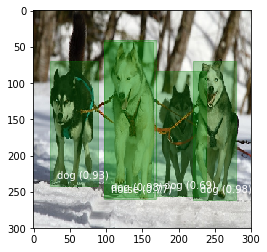

In [0]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.imshow(image)

# plot boxes exceeding score threshold
for det in parse_out[0][:5]:
    bbox = det['bbox']
    # scale box to image coordinates
    box = bbox * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])

    # display rectangle
    patch = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],  color='g', alpha=0.3)
    ax.add_patch(patch)

    # display class index and score
    plt.text(x=box[0] + 10, y=box[3] - 10, s='%s (%0.2f) ' % (classes_90[det['label']], det['confidence']), color='w')
    
plt.show()

推論にかかる時間を導出します。1バッチサイズの300x300の画像の50サンプルの推論時間を導出しています。
TensorFlow-TensorRTに比べTensorFlowのレイヤーにフォールバックしたレイヤーがないので高速に推論ができます。

In [0]:
%%time
import time
num_samples = 50
batch_size = 1

t0 = time.time()
for i in range(num_samples):
    outputs = execute_trt(context, engine, bgr8_to_ssd_input(image))
t1 = time.time()
print('Average runtime: %f seconds' % (float(t1 - t0) / (num_samples * batch_size)))

Average runtime: 0.073022 seconds
CPU times: user 1.05 s, sys: 104 ms, total: 1.15 s
Wall time: 3.65 s
